In [ ]:
#load in the data
#split data into training and validation data
#use training data to run different evaluation
#evaluate performance on validation data
#different classifiers could be: knearestneighbors (with different neighbors, decisiontreeclasifier)
#analyse results by comparing classifiers on different metrics, inspecting images that are classifies incorrectly etc
#select best classifier (by which rules should we select)
#create python script that takes an image, measures the features, classifies the image
#and gives its probability of being a melanoma (range from 0 to 1)

## Features

* Perimeter
* Area
* Compactness
* Asymmetry
* !color

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Config
from PIL import Image 
import os, Config
from skimage import morphology
from statsmodels.robust import mad
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
def load_picture(iid):
    path_mask = '../data/example_segmentation'
    file_mask = path_mask + os.sep + image_id[iid] + '_segmentation.png'
    picture = Image.open(file_mask)
    return picture

In [ ]:
class Picture:
    def __init__(self, img, img_bw):
        self.img = img
        self.img_bw = self.cut_image(img_bw)

    #ASYMMETRY
    def cut_image(self, picture):
        width, height = picture.size
        image = np.array(picture)
        
        if width %2 != 0:
            image = np.delete(image, -1, 1)

        if height %2 != 0:
            image = np.delete(image, -1, 0)

        image = Image.fromarray(image)

        return image

    def _asymmetry(self, rot_img):
        ''' get the asymmetry between the left and right part of a given binary mask '''
        width, height = rot_img.size #mask should be quadratic and therefore have equal dimension
        size = width * height

        #check for uneven number of pixels (should not happen but just as a precaution)
        if width %2 != 0:
            raise TypeError("Uneven number of pixel and cannot be symmetric")
        
        #cut in half and fold
        left = rot_img.crop((0, 0, (width/2), height)) #left part of picture (left, top, right, bottom)
        right = rot_img.crop(((width/2), 0, width, height)) #right part of picture
        right = right.transpose(Image.FLIP_LEFT_RIGHT) #flip right part to compare

        #get the binary difference between left an right
        symmetry = np.where(np.array(left) != np.array(right), 1, 0)

        return np.sum(symmetry) / (size/2) #the percentage of asymmetry 
    
    def get_asymmetry(self):
        ''' get the asymmetry for a given mask by folding it in half from multiple angles'''
        return round(np.mean([self._asymmetry(self.img_bw), self._asymmetry(self.img_bw.rotate(30, expand= True)),self._asymmetry(self.img_bw.rotate(60, expand= True)),self._asymmetry(self.img_bw.rotate(90, expand= True))]),2)

    #BORDER
    def measure_area_perimeter(self): #Stolen from Veronika's github
    # Measure area: the sum of all white pixels in the mask image
        mask = np.where(np.array(self.img_bw)==255, 1, 0)
        area = np.sum(mask)

        # Measure perimeter: first find which pixels belong to the perimeter.
        struct_el = morphology.disk(1)
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        image_perimeter = mask - mask_eroded

        # Now we have the perimeter image, the sum of all white pixels in it
        perimeter = np.sum(image_perimeter)

        return area, perimeter

    def get_compactness(self):
        ''' Computes and returns the compactness of a figure '''
        area, perimeter = self.measure_area_perimeter()
        return round(4*np.pi*area / perimeter ** 2, 4)


    #COLOR
    def get_color_variability(self):
        '''
            Assigns a color variability score
        '''
        if self._check_variability() < 20: 
            return 0 
        elif self._check_variability() < 50: 
            return 1
        else: 
            return 2

    def _check_variability(self):
        '''
            Returns a mean of the median absolute deviation of each color (rgb)
        '''
        self.img[self.img_bw==0] = 0
        
        #we then calculate the mad of each dimension 
        r, g, b = self.img[:,:,0], self.img[:,:,1], self.img[:,:,2]
        mad_r= mad(r[np.where(r != 0)])
        mad_g= mad(g[np.where(g != 0)])
        mad_b= mad(b[np.where(b != 0)])
        mad_result= [mad_r,mad_g,mad_b]

        #calculating the mean
        return np.mean(mad_result)

In [ ]:
def get_row(pict, pic):  
    assym = pict.get_asymmetry()
    comp = pict.get_compactness()
    color = pict.get_color_variability()

    melanoma = groundtruth[groundtruth['image_id'] == pic]['melanoma'].iloc[0]
#    return assym, comp, color, melanoma
    return pd.DataFrame([[pic, assym, comp, color, melanoma]], 
                        columns=['ISIC', 'Asymmetry', 'Compactness', 'Color', 'Melanoma'])


In [ ]:
def train_evaluate_classifiers(df):
    testies = df

    X = testies[["Asymmetry", "Compactness","Color"]]
    y = testies["Melanoma"]

    #split data set into a train, test and valification set
    #X_dev, X_test, y_dev, y_test = train_test_split(
    #    X, y, test_size= 0.3, stratify=y, random_state=0)

    X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, stratify=y, random_state=0)

    #X_train, X_val, y_train, y_val = train_test_split(
    #    X_dev, y_dev, test_size= 0.5, stratify=y_dev)

    X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev)

    #train a classifier
    # knn1 = KNeighborsClassifier(n_neighbors=1)
    # knn1trained = knn1.fit(X_train, y_train)

    # knn3 = KNeighborsClassifier(n_neighbors=3)
    # knn3trained = knn3.fit(X_train, y_train)

    # loglen = int(np.log(len(df['Melanoma'])))
    # knnlog = KNeighborsClassifier(n_neighbors=loglen)
    # knnlogtrained = knnlog.fit(X_train, y_train)

    # tree = DecisionTreeClassifier()
    # treetrained = tree.fit(X_train, y_train)
    
    # gauss = GaussianNB()
    # gausstrained = gauss.fit(X_test, y_test)

    # #evaluate the classifiers
    # y_val_knn1 = knn1trained.predict(X_val)
    # y_val_knn3 = knn3trained.predict(X_val)
    # y_val_knnlog = knnlogtrained.predict(X_val)
    # y_val_tree = treetrained.predict(X_val)
    # y_val_gauss = gausstrained.predict(X_val)

    all_acc = []
    all_roc = []

    for i in range(1,7):
        knn = KNeighborsClassifier(n_neighbors= i)
        knntrained = knn.fit(X_train, y_train)
        if i == 4:
            k4 = knntrained
        y_val_knn = knntrained.predict(X_val)
        acc = accuracy_score(y_val, y_val_knn)
        roc = roc_auc_score(y_val, y_val_knn)
        all_acc.append(acc)
        all_roc.append(roc)


    sns.set()
    fig, ax = plt.subplots(figsize = (10,5))
    
    ax1 = ax.plot(range(1,7), all_acc, label="accuracy score", color = "#f0a073")
    twin = ax.twinx()
    ax2 = twin.plot(range(1,7), all_roc, label = "roc auc score", color = "#9a9d70")
    

    axes = ax1+ax2
    labs = [l.get_label() for l in axes]
    ax.legend(axes, labs, loc=0)

    ax.set_ylabel("Accuracy score")
    twin.set_ylabel("ROC AUC score")
    ax.set_xlabel("Number of Neighbors in KNN model")

    return k4
    
    # print("Accuracy (using numpy)")
    # print(f"knn 1: {np.sum(y_val_knn1 == y_val)/ np.size(y_val)*100}")
    # print(f"knn 3: {np.sum(y_val_knn3 == y_val)/ np.size(y_val)*100}")
    # print(f"knn log: {np.sum(y_val_knnlog == y_val)/ np.size(y_val)*100}")
    # print(f"tree: {np.sum(y_val_tree == y_val)/ np.size(y_val)*100}")
    # print(f"gauss: {np.sum(y_val_gauss == y_val)/ np.size(y_val)*100}")

    # print("Accuracy score")
    # print(f"knn 1: {accuracy_score(y_val,y_val_knn1)}")
    # print(f"knn 3: {accuracy_score(y_val,y_val_knn3)}")
    # print(f"knn log: {accuracy_score(y_val,y_val_knnlog)}")
    # print(f"tree: {accuracy_score(y_val,y_val_tree)}")
    # print(f"gauss: {accuracy_score(y_val,y_val_gauss)}")

    # print("roc auc score")
    # print(f"knn1: {roc_auc_score(y_val, y_val_knn1)}")
    # print(f"knn3: {roc_auc_score(y_val, y_val_knn3)}")
    # print(f"knnlog: {roc_auc_score(y_val, y_val_knnlog)}")
    # print(f"tree: {roc_auc_score(y_val, y_val_tree)}")
    # print(f"gauss: {roc_auc_score(y_val, y_val_gauss)}")

    


    > Load the CSV with ISIC names and "ground truth"
    > Start adding features to the data frame
    > Split the data frame into testing and training - start training
    > Train a classifier
        - Nearest neighbour with k neighbours
        - Decision tree
        - Bayes classifier
    

In [ ]:
groundtruth = pd.read_csv(Config.example_ground_truth_path)

In [ ]:
def main(features_df=None):

    image_names = [ID for ID in groundtruth['image_id']]
    if not features_df.empty: # If there is an error here, remove '.empty' it only needs to be there if you pass a dataframe
        features_df = pd.DataFrame(columns=['ISIC', 'Asymmetry', 'Compactness', 'Color', 'Melanoma'])#, index=range(50))
        for pic in image_names:
            img_bw = Image.open(Config.mask_path + os.sep + pic + '_segmentation.png') # open mask image

            img = plt.imread(Config.images_path + os.sep + pic + '.jpg') # open image
            pict = Picture(img = img, img_bw = img_bw)
            tempdf = get_row(pict, pic)
            features_df = pd.concat([features_df, tempdf], axis=0, ignore_index=True)

    return train_evaluate_classifiers(features_df), features_df




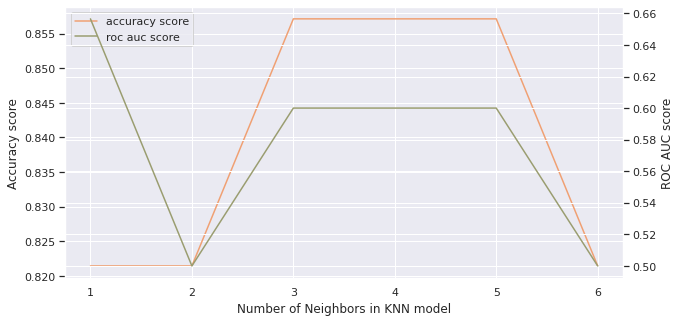

In [ ]:
knntrained, tfeatures_df = main(tfeatures_df)

In [ ]:
tfeatures_df.empty

False

In [ ]:
pic = 'ISIC_0001852'
img = plt.imread(Config.images_path + os.sep + pic + '.jpg')
img_bw = Image.open(Config.mask_path + os.sep + pic + '_segmentation.png')
pict = Picture(img, img_bw)

tempdf = get_row(pict, pic)

prediction = knntrained.predict(tempdf[['Asymmetry', 'Compactness', 'Color']])

print(prediction)

[0.]


In [ ]:
KNeighborsClassifier

sklearn.neighbors._classification.KNeighborsClassifier

In [ ]:
df = pd.DataFrame(columns=['ISIC', 'Asymmetry', 'Compactness', 'Color', 'Melanoma'], index=['im'])
df2 = pd.DataFrame(
        [[1, 2, 3, 4, 5]], 
        columns=['ISIC', 'Asymmetry', 'Compactness', 'Color', 'Melanoma'], index=['ig'])

df.append(df2)

df

   ISIC Assymetry Compactness Color Melanoma
im  NaN       NaN         NaN   NaN      NaN


,ISIC,Assymetry,Compactness,Color,Melanoma
im,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = pd.DataFrame([[1, 2], [3, 4]], columns=list('AB'), index=['x', 'y'])

df2 = pd.DataFrame([[5, 6], [7, 8]], columns=list('AB'), index=['x', 'y'])
df.append(df2)

df

,A,B
x,1,2
y,3,4


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=932aa97b-f6d2-4889-8f04-d6166675cc2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>